In [1]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# TODO: store the images as matrices or tensors as they take forever to load.
path = "/kaggle/input/deepglobe-land-cover-classification-dataset/"

input_shape = (512, 512, 3)
out_shape = (512, 512, 3)
img_shape = (2448, 2448, 3)

In [3]:
def preprocess_img(img, shape):
    
    image = cv2.imread(img)
    assert image is not None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out = np.array(cv2.resize(image, shape, interpolation = cv2.INTER_LINEAR),
                   dtype = np.uint8)
    return out
    
def preprocess_mask(img, shape):
    
    mask = np.array(np.round(preprocess_img(img, shape) / 255.0), dtype = np.uint8)
    mask_refined = 4 * mask[:,:,0] + 2 * mask[:,:,1] + mask[:,:,2]
    
    return mask_refined

def get_dataset(path):
    
    mask_dirs = sorted(glob.glob(os.path.join(path,"*_mask.png")))
    sat_dirs = [d.replace("_mask.png", "_sat.jpg") for d in mask_dirs]
    
    X = tf.convert_to_tensor([preprocess_img(file, input_shape[:2]) for file in sat_dirs], dtype = tf.float16)
    y = tf.convert_to_tensor([preprocess_mask(file, out_shape[:2]) for file in mask_dirs], dtype = tf.uint8)
    y = tf.reshape(y, y.shape + (1,))
    
    #np.save("X_train.np",X.numpy())
    #np.save("y_train.np",y.numpy())
    
    return X, y

In [4]:
X_train, y_train = get_dataset(os.path.join(path, "train"))
#X_val, y_val = get_dataset(os.path.join(path, "valid"))
#X_test, y_test = get_dataset(os.path.join(path, "test"))

In [5]:
#X_train = tf.convert_to_tensor(np.load("/kaggle/working/first100X.np.npy"), dtype = tf.float16)
#y_train = tf.convert_to_tensor(np.load("/kaggle/working/first100X.np.npy"), dtype = tf.uint8)

In [6]:
class ConvBlock(tf.keras.Model):
    
    def __init__(self, n_filters, filter_size, stride, pool_stride):
        super().__init__()
        self.cn = tfl.Conv2D(n_filters, filter_size, strides = stride,
                            padding = "same")
        self.relu = tfl.ReLU()
        self.pool = tfl.MaxPooling2D(pool_stride)
        
    def call(self, inputs):
        
        x = self.cn(inputs)
        #x = self.bn(x)
        x = self.relu(x)
        x = self.pool(x)
        
        return x

In [7]:
class DeconvBlock(tf.keras.Model):
    
    def __init__(self, filters, filter_size, stride):
        super().__init__()
        self.dcn = tfl.Conv2DTranspose(filters, filter_size, stride, padding = "same")

    def call(self, inputs):
        
        x = self.dcn(inputs)
        
        return x

In [8]:
# TODO:
# Read the FCN paper
# Add the UNET skip connections.

class UNET(tf.keras.Model):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = ConvBlock(64, 3, 1, 2)
        self.conv2 = ConvBlock(128, 3, 1, 2)
        self.conv3 = ConvBlock(256, 3, 1, 2)
        #self.conv4 = ConvBlock(384, 3, 1, 2)
        #self.conv5 = ConvBlock(256, 3, 1, 2)
        self.fc1 = ConvBlock(256, 3, 1, 1)
        self.fc2 = ConvBlock(256, 3, 1, 1)
        #self.fc3 = ConvBlock(8, 1, 1, 1)
        self.dcn1 = DeconvBlock(256, 3, 2)
        self.dcn2 = DeconvBlock(128, 3, 2)
        self.dcn3 = DeconvBlock(64, 3, 2)

        self.conv4 = ConvBlock(128, 1, 1, 1) # 1*1 conv not yet used
        self.conv5 = ConvBlock(256, 1, 1, 1) # 1*1 conv not yet used

        self.softmax = tfl.Softmax()
    
    def call(self, x):
        
        x1 = self.conv1(x) 
        x2 = self.conv2(x1) 
        x3 = self.conv3(x2) 
        #x = self.conv4(x)
        #x = self.conv5(x)
        
        x = self.fc1(x3)
        x = self.fc2(x)
        #x = self.fc3(x)

        x = self.dcn1(tf.concat([x, x3], axis = -1))
        x = self.dcn2(tf.concat([x, x2], axis = -1)) 
        x = self.dcn3(tf.concat([x, x1], axis = -1))

        x = self.conv4(x)
        x = self.conv5(x)
    
        x = self.softmax(x)
        
        return x

In [9]:
inputs = tf.keras.Input(input_shape)
model = UNET()

model(inputs)

<KerasTensor shape=(None, 512, 512, 256), dtype=float32, sparse=False, name=keras_tensor_12>

In [10]:
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_block (ConvBlock)          │ ?                      │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_1 (ConvBlock)        │ ?                      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_2 (ConvBlock)        │ ?                      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_3 (ConvBlock)        │ ?                      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_4 (ConvBlock)        │ ?                      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_block (DeconvBlock)      │ ?                      │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_block_1 (DeconvBlock)    │ ?                      │       442,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ deconv_block_2 (DeconvBlock)    │ ?                      │       110,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_5 (ConvBlock)        │ ?                      │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block_6 (ConvBlock)        │ ?                      │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,325,376 (12.69 MB)

 Trainable params: 3,325,376 (12.69 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
optimizer = tf.keras.optimizers.AdamW(3e-5)
model.compile(loss = loss_fn, optimizer = optimizer)

In [12]:
def to_img(y):
    
    out = np.zeros(y.shape[:2] + (3,))
    
    out[:, :, 0] = (y // 4) * 255
    out[:, :, 1] = ((y % 4) // 2) * 255
    out[:, :, 2] = (y % 2) * 255

    return out

In [13]:
EPOCHS = 50

history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 8, validation_split = 0.2)

Epoch 1/50


I0000 00:00:1765391951.172633      70 service.cc:145] XLA service 0x795e340048c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765391951.172728      70 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1765391951.539154      70 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1765391976.382205      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


80/81 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step - loss: 5.0463

W0000 00:00:1765392008.753511      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 506ms/step - loss: 5.0312

W0000 00:00:1765392018.050847      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1765392020.948087      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


81/81 ━━━━━━━━━━━━━━━━━━━━ 74s 571ms/step - loss: 5.0166 - val_loss: 2.6871
Epoch 2/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 432ms/step - loss: 2.4909 - val_loss: 2.1882
Epoch 3/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 434ms/step - loss: 2.2226 - val_loss: 1.8330
Epoch 4/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.9856 - val_loss: 1.7287
Epoch 5/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.8487 - val_loss: 1.5043
Epoch 6/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.5291 - val_loss: 1.2918
Epoch 7/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.3149 - val_loss: 1.2695
Epoch 8/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.2722 - val_loss: 1.2029
Epoch 9/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.2146 - val_loss: 1.1812
Epoch 10/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 434ms/step - loss: 1.1817 - val_loss: 1.0573
Epoch 11/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 433ms/step - loss: 1.1770 - val_loss: 0.9906
Epoch 12/50
81/81 ━━━━━━━━━━━━━━━━━━━━ 35s 434ms/ste

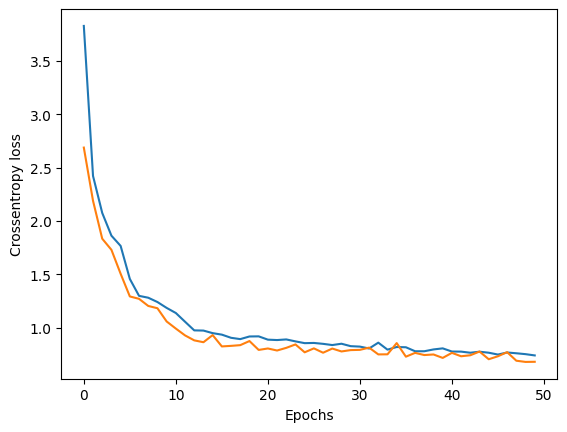

In [14]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

In [15]:
def predict_mask(X_target):
    if len(X_target.shape) == 3:
        # Add batch dimension
        X_target = tf.reshape(X_target, (1,) + X_target.shape)
        
    y_pred = tf.argmax(model(X_target), axis = -1)[0]
    
    return y_pred

In [16]:
import seaborn as sns

def confusion_matrix_show(cm):
    class_labels = list(range(8))
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                cmap='Blues',  # Optional: Set a color map
                xticklabels=class_labels, 
                yticklabels=class_labels)
    
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top') 
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [17]:
def Visualize_output(X_target, y_target):
    y_pred = predict_mask(X_target)
    img_pred = to_img(y_pred)
    img_real = to_img(y_target[:,:,0])
    
    cm = confusion_matrix(tf.reshape(y_target[:,:,0],(-1)), tf.reshape(y_pred, (-1)), labels = np.arange(8))
    confusion_matrix_show(cm)
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot first image
    axes[0].imshow(img_pred, interpolation = 'nearest')
    axes[0].axis('off')
    axes[0].set_title("Predicted mask:")
    
    # Plot second image
    axes[1].imshow(img_real, interpolation = 'nearest')
    axes[1].axis('off')
    axes[1].set_title("Real mask:")
    
    # Display the images
    plt.tight_layout()
    plt.show()

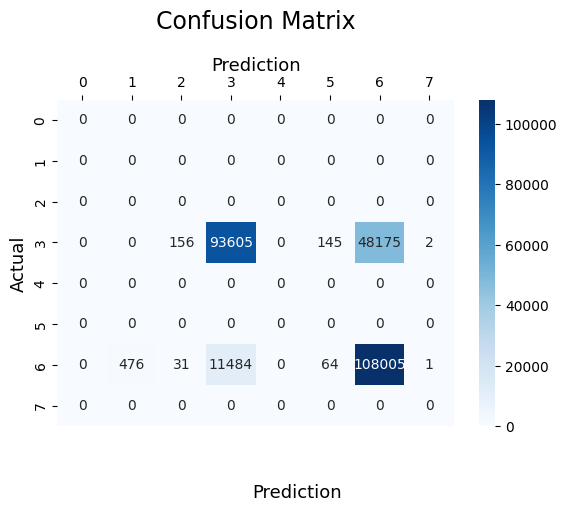

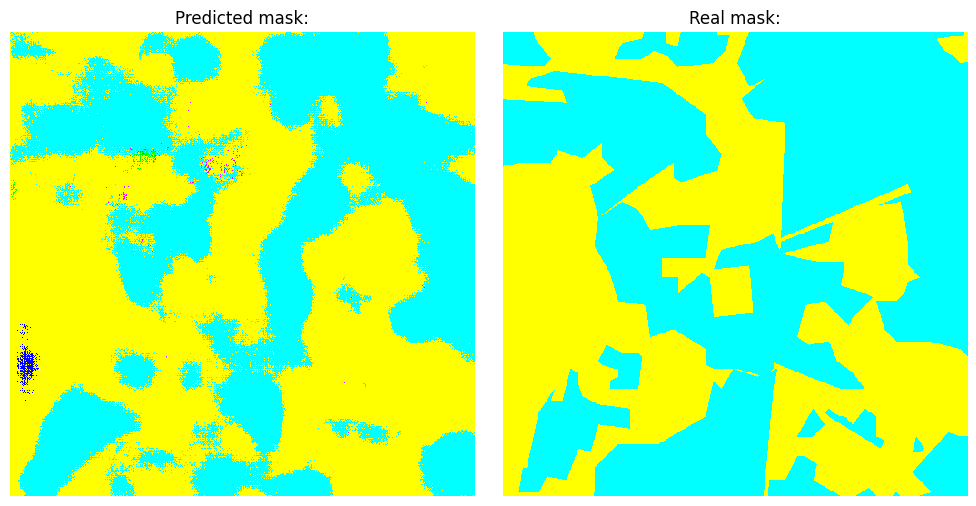

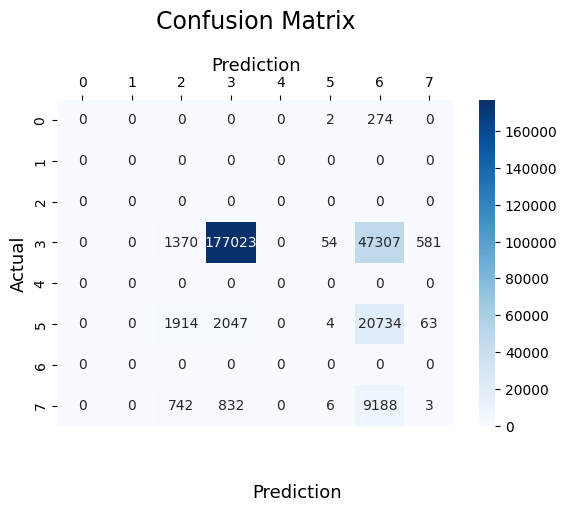

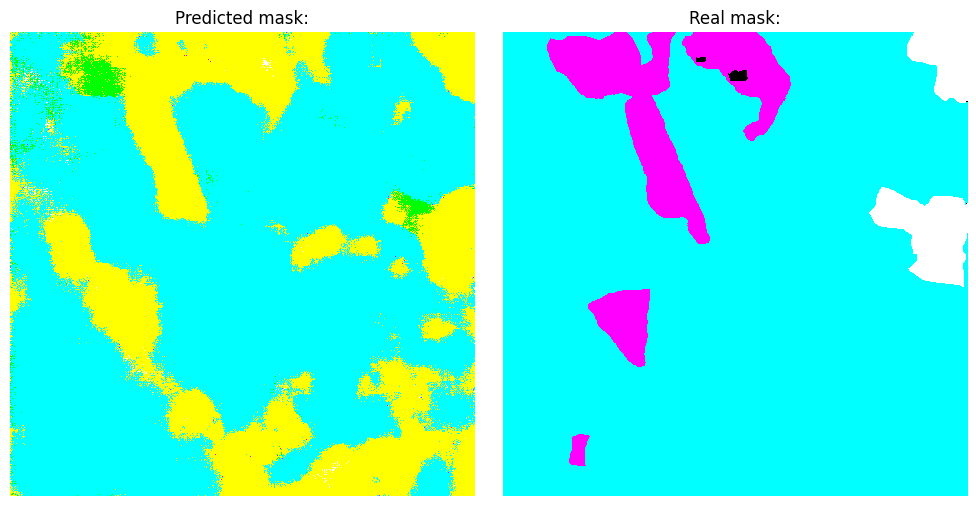

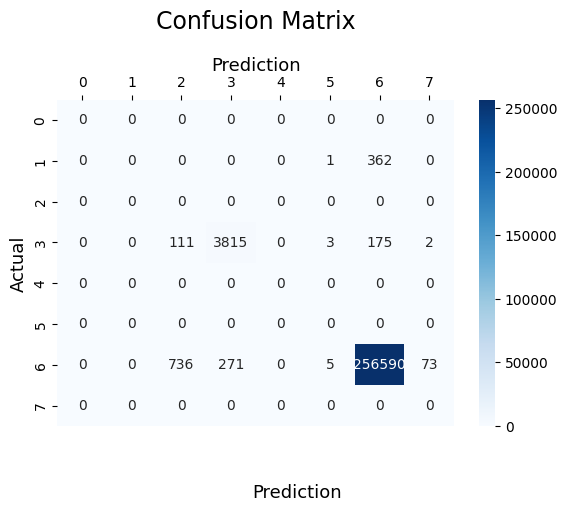

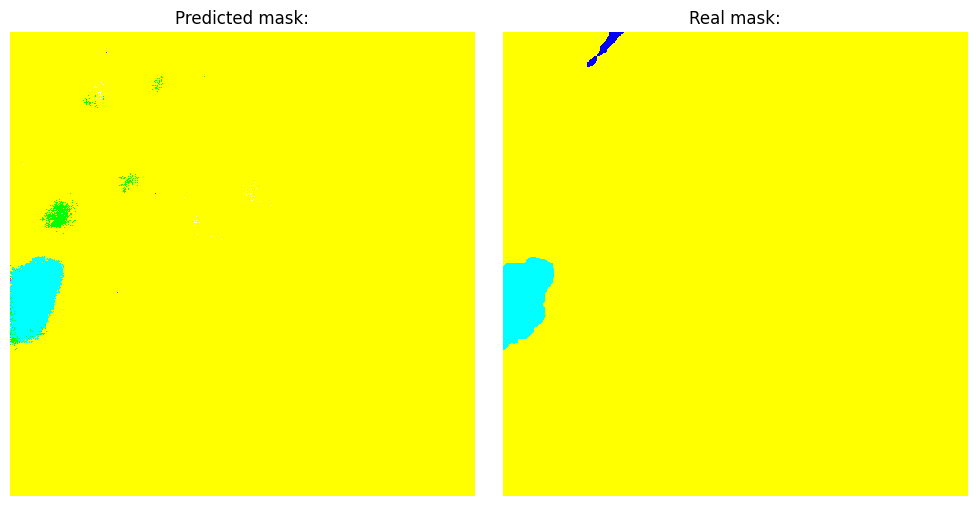

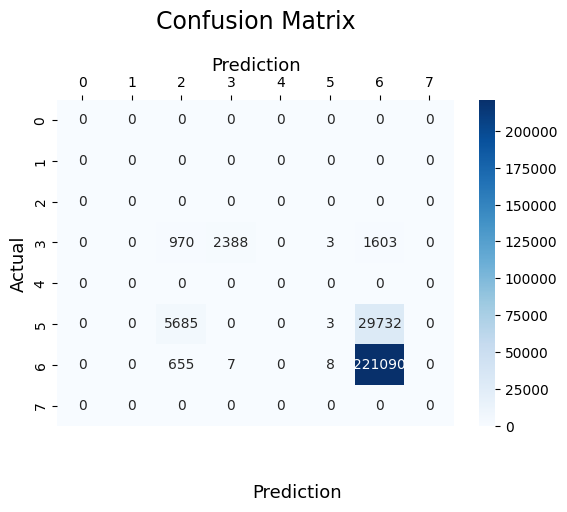

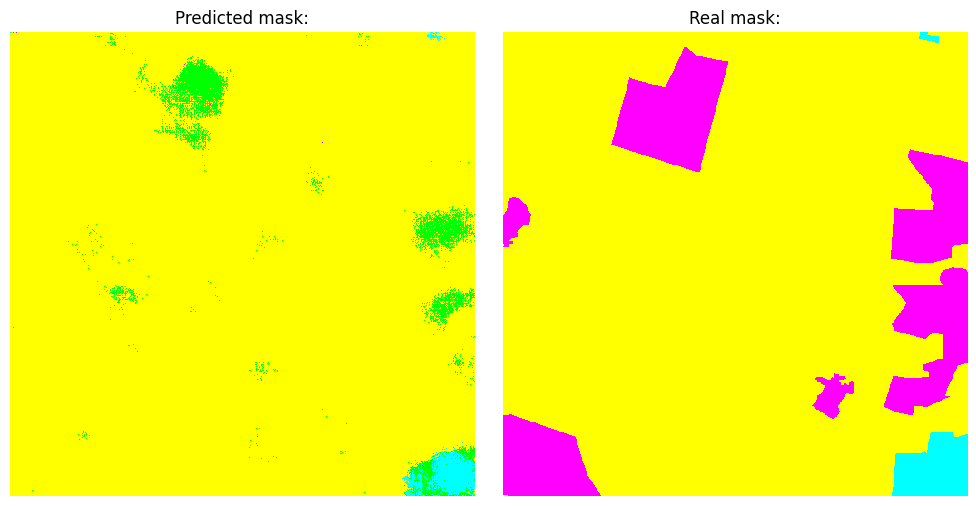

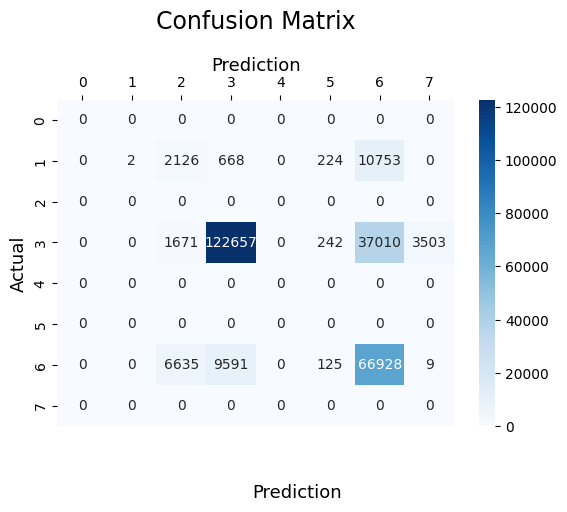

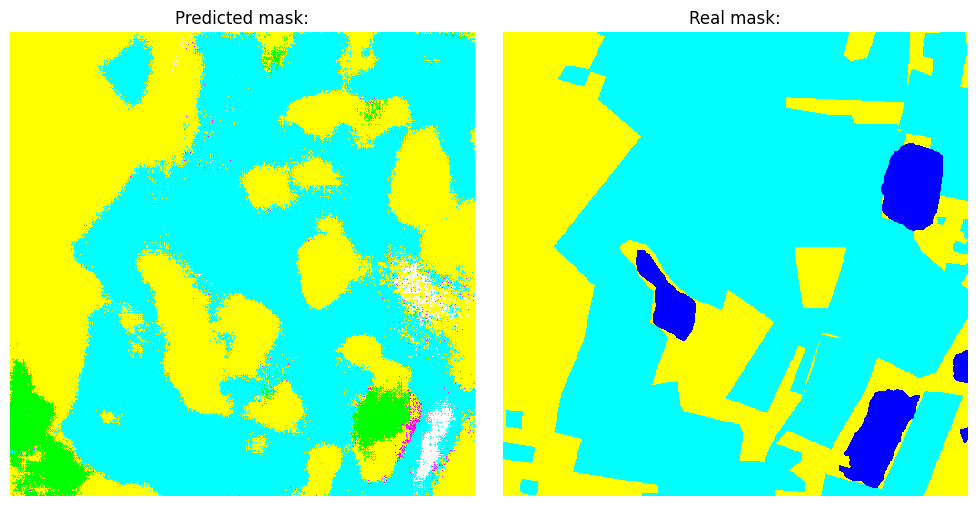

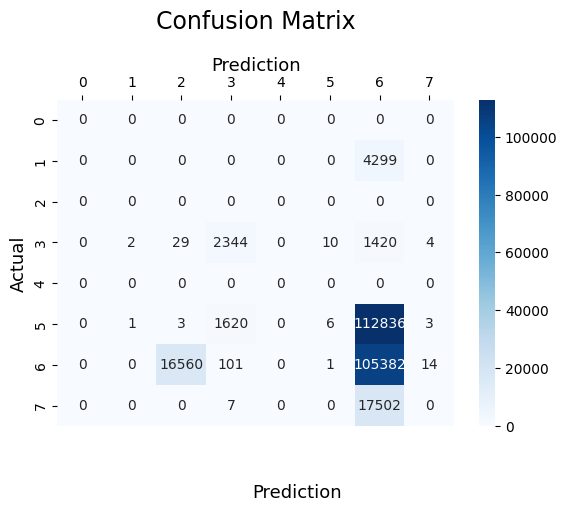

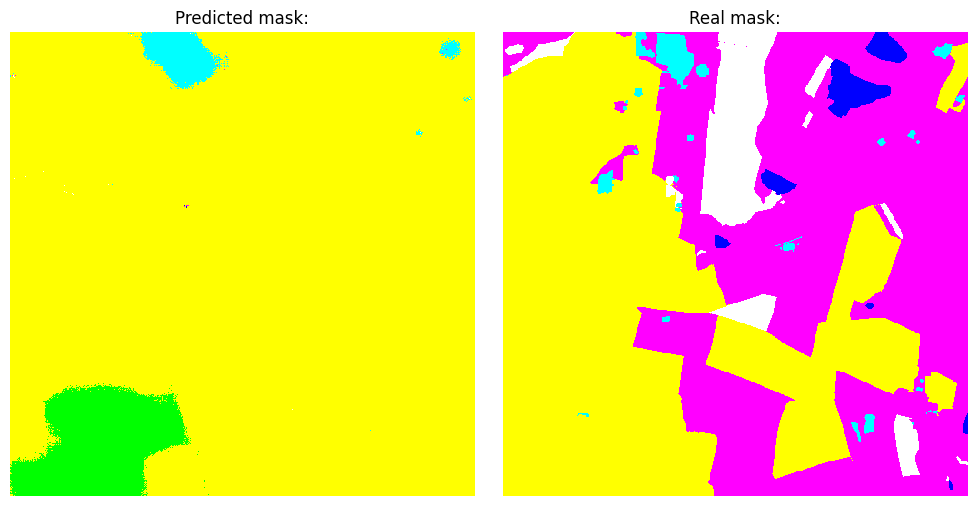

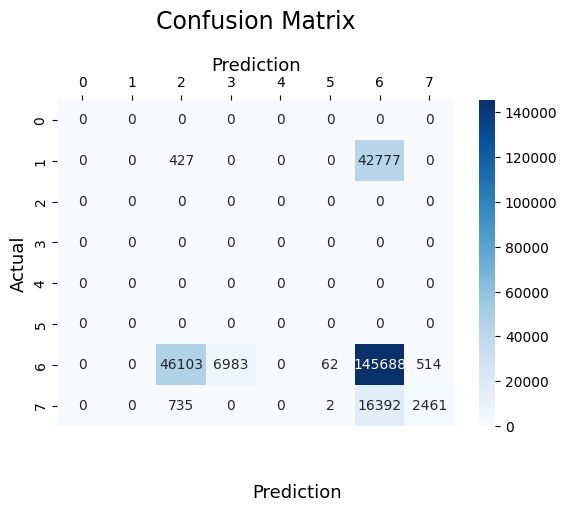

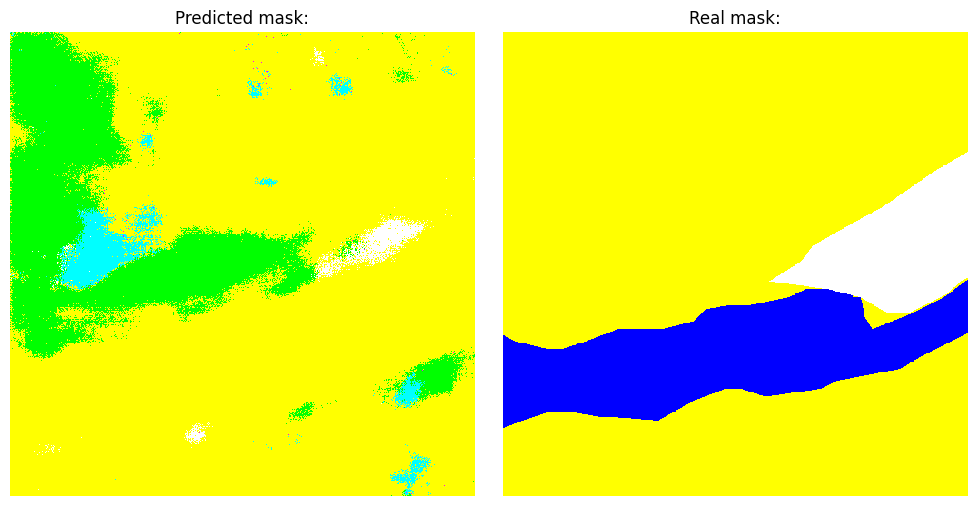

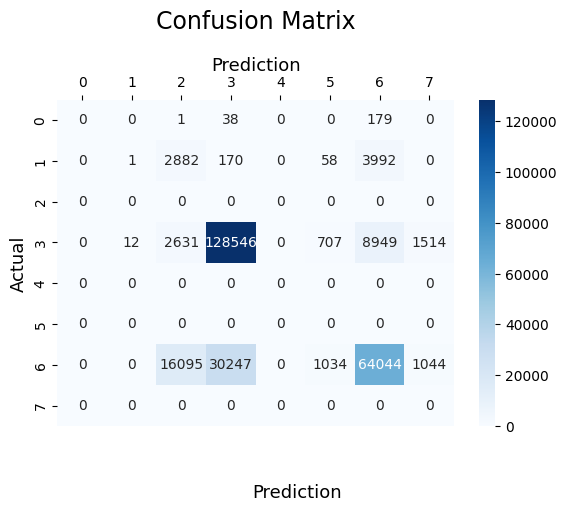

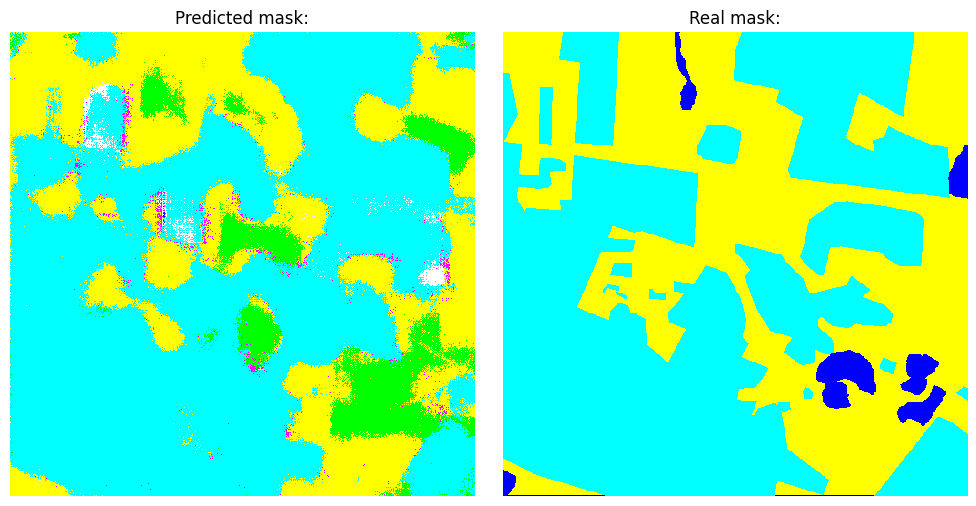

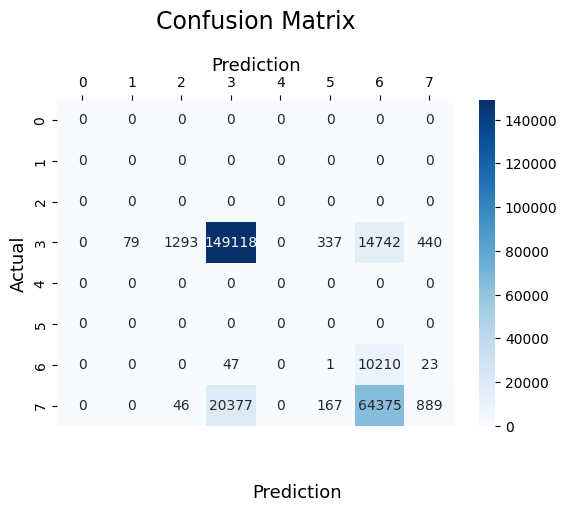

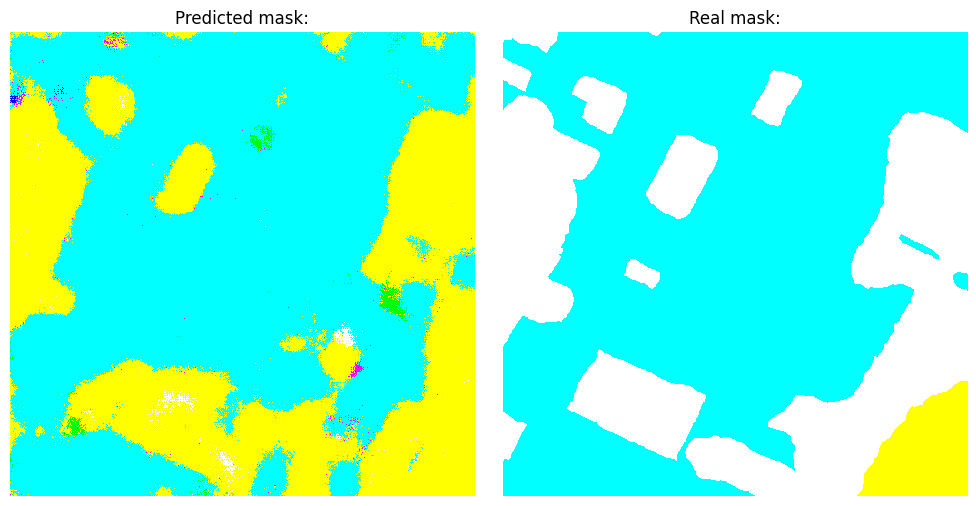

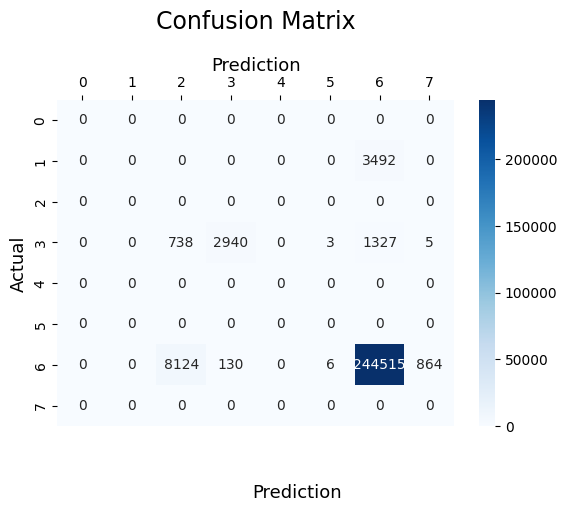

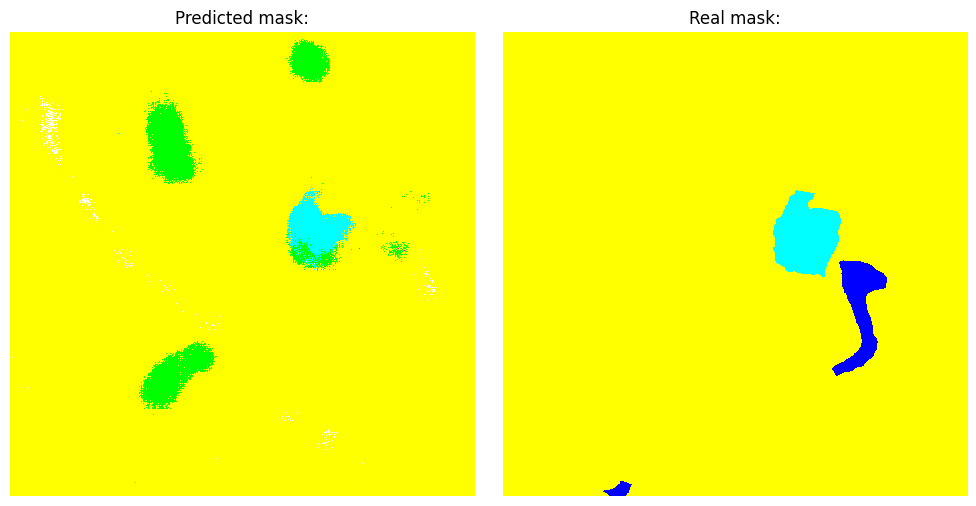

In [18]:
random_indices = np.random.randint(0, X_train.shape[0], 10)

for i in random_indices:
    Visualize_output(X_train[i], y_train[i])